# Кошки против собак

Распознавание фотографий котиков и их отличие от собак является давней проблемой, которая волнует человечество. В 2007 году считалось, что точность распознавания не может привысить 60%. Давайте посмотрим, какой точности нам удастся достичь!

В качестве исходных данных мы берем набор [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data) с сайта [Kaggle](http://kaggle.com). Предполагаем следующую конфигурацию входных данных:

   * Все картинки распакованы в директорию `C:\Cats_Dogs`
   * Файлы с отображением картинок на категории находятся в той же директории с именами `Test.txt` и `Train.txt`

In [10]:
import os

source_dir = r'd:\Cats_Dogs'
train_file = os.path.join(source_dir,'Train.txt')
test_file = os.path.join(source_dir,'Test.txt')

test_epoch_size = 5000
train_epoch_size= 20000

Для начала импортируем все необходимые модули для работы Cognitive Toolkit и задаём вычисления с использованием графического процессора

In [2]:
import cntk
from cntk.io import *
from cntk.io.transforms import *
from cntk.layers import *
from cntk.ops import *
import numpy as np

cntk.set_default_device(cntk.device.gpu(0))

True

Задаём разрешение модели. Будем масштабировать картинки до $64\times64$ пикселей, при этом распознавать два класса - кошки (0) и собаки (1).

In [3]:
# Задаём разрешение модели
image_height = 64
image_width = 64
num_channels = 3
num_classes = 2


Для чтения входных данных с диска используется `reader` (который также называется `MinibatchSource`). При этом мы можем задавать преобразования, которые на лету будут происходить с входными данными - это полезно для реализации **Data Augmentation**. В нашем случае мы используем случайный crop.
После этого создаём объекты для чтения данных из входных файлов.

In [5]:
def create_reader(map_file,train):
    trans = []
    if train: trans += [crop(crop_type='randomside',side_ratio=0.8)]
    trans += [scale(width=image_width,height=image_height,channels=num_channels)]
    return MinibatchSource(ImageDeserializer(map_file, StreamDefs(
        features = StreamDef(field='image',transforms=trans), # first column in map file is referred to as 'image'
        labels   = StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )))

reader_train = create_reader(train_file,True)
reader_test = create_reader(test_file,False)


### Архитектура сети
Описываем архитектуру нашей нейронной сети. В нашем случае мы будем использовать свёрточную сеть с тремя свёрточными слоями и двумя промежуточными полносвязными слоями. Функция активации по умолчанию - `relu`. `model` - это функция, которая может быть применена ко входным переменным для получения результата.

In [6]:
model = Sequential([
    LayerStack(3, lambda i: [
        Convolution((5,5), [32,32,64][i], init=glorot_uniform(), pad=True,activation=relu),
        BatchNormalization(map_rank=1),
        MaxPooling((3,3), strides=(2,2))
    ]),
    #Dropout(0.1),
    Dense(64, init=glorot_uniform(),activation=relu),
    Dense(64, init=glorot_uniform(),activation=relu),
    #Dropout(0.25),
    Dense(num_classes, init=glorot_uniform(), activation=None)
])


$\def\model{\rm model}
\def\input{\rm input}
$
Далее определяем саму нейросеть: входные переменные (это переменные, соответствующие входным фичам - пикселям изображения, и выходным категориям). После этого граф вычислений сети определяется по формуле $$z = \model(\input)$$.
На самом деле мы здесь же производим нормирование входных величин, приводя их к диапазону $[-1;1]$, т.е. формула имеет вид $$z = \model({1\over256}\times(\input-128)$$.
Переменные (тензоры) `ce` и `pe` определяют ошибку cross-entropy loss и ошибку классификации, соответственно.

In [8]:
input_var = input_variable((num_channels, image_height, image_width))
label_var = input_variable((num_classes))

input_var_norm = element_times(1.0/256.0, minus(input_var,128.0))
    
z = model(input_var_norm)

ce = cntk.cross_entropy_with_softmax(z, label_var)
pe = cntk.classification_error(z, label_var)

### Определяем алгоритм обучения
Далее задаём алгоритм обучения `learner` и обучающий объект `trainer`. При этом мы описываем, как будет изменяться скорость обучения *learning rate* по мере обучения в зависимости от количества эпох.

In [12]:
minibatch_size = 64

lr_per_minibatch = cntk.learning_rate_schedule([0.01] * 10 + [0.003] * 10 + [0.001], cntk.UnitType.minibatch, train_epoch_size)
    
learner = cntk.adagrad(z.parameters, lr = lr_per_minibatch)
trainer = cntk.Trainer(z, (ce, pe), [learner])

input_map = {
    input_var: reader_train.streams.features,
    label_var: reader_train.streams.labels
}

cntk.logging.log_number_of_parameters(z)


Training 284642 parameters in 18 parameter tensors.


В процессе обучения нам будет полезно контролировать качество обучения на тестовой выборке. Для этого мы определим функцию, которая проходится по всей тестовой выборке и вычисляет совокупную ошибку (в процентах)

In [13]:
def test_eval():
    test_epoch_size = 5000
    minibatch_size = 16

    metric_numer = 0
    metric_denom = 0
    sample_count = 0
    minibatch_index = 0

    while sample_count < test_epoch_size:
        current_minibatch = min(minibatch_size, test_epoch_size - sample_count)
        data = reader_test.next_minibatch(current_minibatch, input_map=input_map)
        metric_numer += trainer.test_minibatch(data) * current_minibatch
        metric_denom += current_minibatch
        sample_count += data[label_var].num_samples
        minibatch_index += 1

    return (metric_numer * 100.0) / metric_denom


### Приступаем к обучению!
Теперь всё готово для обучения! Определяем количество эпох и запускаем процесс обучения!

In [15]:
max_epochs = 3
progress_printer = cntk.logging.ProgressPrinter(tag='Training',num_epochs=max_epochs)

for epoch in range(max_epochs):
    sample_count = 0
    n=0
    while sample_count < epoch_size:
        data = reader_train.next_minibatch(min(minibatch_size, epoch_size - sample_count), input_map=input_map) # fetch minibatch.
        t = trainer.train_minibatch(data)
        sample_count += data[label_var].num_samples                        
        progress_printer.update_with_trainer(trainer, with_metric=True) # log progress
        n+=1

    progress_printer.epoch_summary(with_metric=True)
    print("Evaluation result: {:0.1f}".format(test_eval()))
    trained_model = cntk.softmax(z)
    #trained_model.save_model('c:\\Learn\\Models\\CatDog_' + str(epoch))

trained_model.save_model(os.path.join(source_dir,'Model'))

Finished Epoch[1 of 3]: [Training] loss = 0.556986 * 20000, metric = 28.07% * 20000 46.901s (426.4 samples/s);
Evaluation result: 28.0
Finished Epoch[2 of 3]: [Training] loss = 0.517512 * 20000, metric = 25.44% * 20000 59.260s (337.5 samples/s);
Evaluation result: 25.7
Finished Epoch[3 of 3]: [Training] loss = 0.484402 * 20000, metric = 23.32% * 20000 59.016s (338.9 samples/s);
Evaluation result: 28.5


После обучения полученная нейросеть хранится в тензоре `trained_model`. Для получения на выходе распределения вероятностей мы применяем к выходу сети $z$ функцию `softmax`. Вычислить значение нейросети на некоторых входных данных мы можем с помощью функции `eval`.

In [61]:
from PIL import Image

def evaluate(image_path):
    image_data   = np.array(Image.open(image_path).resize((image_width,image_height)), dtype=np.float32)
    image_data   = np.ascontiguousarray(np.transpose(image_data, (2, 0, 1)))
    return np.squeeze(trained_model.eval({trained_model.arguments[0]:[image_data]}))

import IPython

def show(image_path):
    IPython.display.display(IPython.display.Image(open(image_path,'rb').read(),format='jpg'))
    print(evaluate(image_path))

Посмотрим на нескольких примерах из нашей выборки:

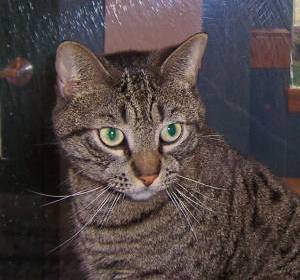

[ 0.63091594  0.36908403]


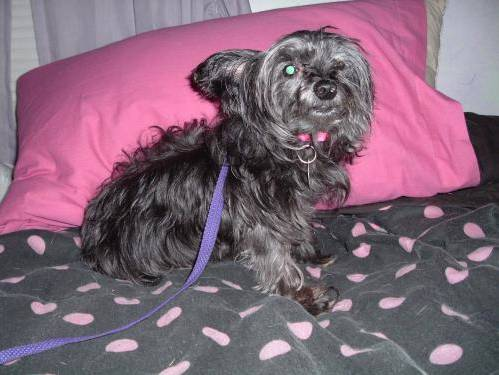

[ 0.19271372  0.80728626]


In [67]:
show(os.path.join(source_dir,'cat.1.jpg'))
show(os.path.join(source_dir,'dog.0.jpg'))

### Проверяем качество модели на тестовой выборке
Вручную переберем все изображение из тестовой выборки и посмотрим, на скольких из них нейросеть правильно угадывать категорию. Для этого опишем функцию `eval_best_cat`, которая возращает номер категории (0 или 1).

In [35]:
def eval_best_cat(image_path):
    result = evaluate(image_path)
    return (-np.array(result)).argsort()[0]

correct = 0; total=0
with open(os.path.join(source_dir,'Test.txt')) as f:
    for x in f:
        cat = int(x.split()[1])
        res = eval_best_cat(x.split()[0])
        if (cat==res): correct+=1
        total+=1

print ("Correct: {} of {}".format(correct,total))

Correct: 3326


В заключении проверим модель на паре произвольных изображений, скачанных из интернет

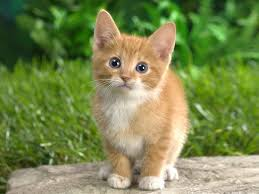

[ 0.14863679  0.85136318]


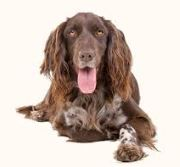

[ 0.3418062   0.65819377]


In [69]:
show('l:\\CIFAR\\Real_Life\\Kitten.jpg')
show('l:\\CIFAR\\Real_Life\\Doggie.jpg')
